# Watershed Model Code
### Connal Boyd
### HW12
### 04/21/22

## Model Description 
This is a steady state, layered box model with recharge, ET, and a stream running through the center of the domain.

#### Dimensions: 
- 50 by 50 by 3
- dx = dy = 1000 m
- Bottom layer is 40 m thick
- Middle layer is 5 m thick

#### Topography
- Land surface 125m above the datum on the left hand side
- sloping linearly to 70m above the datum on the right hand side
- Land surface is controlled by elevation .csv file

#### Subsurface Properties: 
- Homogeneous within layers
- K = 8.5 m/day in x and y and z for all layers
  - Except: K = 0.0001 in z for the right 30 columns of the middle layer 
- Porosity = 0.10
- Specific yield = 0.10
- Storage coefficient=0.0001  

#### Boundary Conditions: 
 - Left boundary is no-flow
 - Top boundary is no-flow
 - Bottom boundary is no-flow
 - Right boundary is a constant head of 70m
 
#### Wells, Recharge, and ET:

- Wells, recharge, and ET values can be found in the assignment description.
     

## 1. Set up the environment

In [18]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv
from matplotlib import ticker

#jupyter specific--included to show plots in notebook
%matplotlib inline 



## 2. Set up the baseline input variables for all models

In [19]:
# Create the model directory
moddir="../../../GW_Homework/Submissions/HW12/mf2005.exe"

# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay_sub=3  #three layers instead of 1

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

with open('base_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)
# print(type(ztop))
#print(ztop.shape)
# print(ztop[0,:])
zbot = 0.     #bottom elevation


## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

# Setup Layers in subsurface
botm = np.zeros((nlay_sub,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                  # bottom elevation of middle layer (1) is 25 m
botm[0,:,:] = 45.  

# Set up K Values for domain
K_horiz = 8.5
K_vert = 8.5

# Make a arrays for the K values
Kz = np.zeros((nlay_sub,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:] = 0.0001                   # Replace the K in the middle layer with the lower value

Kh = np.zeros((nlay_sub,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array

# Subsurface properties
n = 0.10        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.10        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

# Boundary and initial conditions - (for bas file)
# Define cell activity (IBOUND)
ibound = np.ones((nlay_sub, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = 0       # Create left side no-flow boundary
ibound[:,0,:] = 0       # Create top no-flow boundary
ibound[:,-1,:] = 0      # Create bottom no-flow boundary
ibound[:,:,-1] = -1      # Create right constant head boundary

# Create bedrock bounds and no flow boundaries 
for i in range(0,9):
    if i <= 5:                              # Loop to create the top layer of bedrock 
            ibound[0, i, 0:5-i] = 0
            ibound[0, -1-i, 0:5-i] = 0
    elif 6 <= i <= 7:                       # Loop to create the middle layer of bedrock
        for j in range(0,7):
            ibound[1,j,0:7-j] = 0
            ibound[1,-1-j,0:7-j] = 0
    else:
        for k in range(0,9):                # Loop to create the bottom layer of bedrock
            ibound[2,k,0:9-k] = 0
            ibound[2, -1-k, 0:9-k] = 0

# Boundary Head conditions
h_right = 70

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay_sub, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value

## Recharge
recharge = 4e-5 #m/day
rech_zone = np.zeros((1,nrow,ncol))  #define an array of zeros of dim (nrow,ncol)
rech_zone[:,:,0:15] = recharge

# ET
ET_zone = np.zeros((nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[:,25:] = 1e-5
ET_zone[22:28,:] = 5e-4       # ET in Riparian area
# ET_zone[22:28,:] = 5e-5       # ET in Riparian area (most recent version of github)
extinction_depth = 1
#extinction depth is the depth where if our water table is below that, our ET will be ZERO #between surface and extinction depth is just a linear interpolation


## 3. Create No Town, No Ag Model (NTNA)

#### 3.1 Set up the stream package
Could not get the stream package to work properly, so it has been replaced throughout the code by the RIV package. The stream package code has been retained below for further debugging at a later date.

In [20]:
modelname1 = "NTNA_model"
m1 = flopy.modflow.Modflow(modelname1, exe_name = moddir)

# # User inputs:
# nseg = 3
# ntrib = 2
# slope = 0.001                        #slope of streambed (m/m)
# rough = 0.04                         #roughness of streambed

# Flow_into_the_1st_reach = 0    # m^3/day
# Stage_above_datum = 0.5 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

# # str settings
# set_icalc = 1                   #1 if the stage is to be calculated based on flow, otherwise specify below
# const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
# istcb2 = 53                          #save outflows to cbb file

# # Calculate conductivity
# k_strbott = (1.36*K_horiz)                      #river bottom hydraulic conductivity in f/d
# sed_thick = 1                      #thickness of riverbed sediment in f

# str_cond = (k_strbott*(dy)*(width))/(sed_thick) #river bed conductance in f^2/d

# # Setup reach locations
# nreach = 50
# str_rows = 24*np.ones((nreach),dtype=np.int32)
# str_cols = np.arange(0,nreach)

# # Setup reach inflows
# Qreturn = 0        # Return flow from town (Set to zero when town not present in model)
# return_loc = 24     # Cell location of return flow from town to stream
# reach_flow = np.zeros((nreach),dtype=np.int32)      # initially sets all inflows to zero for all reaches
# reach_flow[return_loc] = Qreturn      # inflow to segment 2 --> return from town
# reach_flow[return_loc+1] = -1         # inflow to segment 3 --> sum of all previous segments

# # Setup segment numbers
# segments = np.ones((nreach),dtype=np.int32)
# segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
# segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

# # Setup reach numbers (Numbers reaches within each segment) 
# reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50 (numbering moves downstream)
# reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
# reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

# # Setup the elevation of the stream segments
# ztop = np.genfromtxt('base_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
# surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream
# # loop over the stream reaches and pull the land surface elevation for the location of each stream cell
# for i in np.arange(nreach): 
#       surf_elev[i] = ztop[str_rows[i],str_cols[i]]
# str_top = surf_elev -  1.    # elevation of the top of the streambed (1 m below land surface) (m)
# str_bot = str_top - sed_thick      # elevation of the bottom of the streambed (m)
# stage_elev = str_top + Stage_above_datum      # elevation of the water surface in the stream (m)

# # Setup the stress period dictionary
# str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values
# # Loop over the reaches and setup the data
# for r in np.arange(nreach): 
#      str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], 
#                       str_cond, str_bot[r], str_top[r], width, slope, rough]
# str_spd = {0: str_info} # save the stream info in a stress period dictionary

# # Setup the segments dictionary
# #for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
# seg_info = np.zeros((10,nseg))
# seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
# str_segd = {0: seg_info}  #save the stream info in a segment dictionary

# strm = flopy.modflow.mfstr.ModflowStr(m1, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')


#### 3.2 Set up RIV package

In [21]:
#assign heads at start and end of stress period
strt_head=70
end_head=70
#create list to hold stress period constant head boundary condition cells
bound_sp1 = []

#assign constant head boundary cells on the left and right boundaries
for lay in range(nlay_sub):
    for row in range(nrow):
        bound_sp1.append([lay,row,ncol-1,strt_head,end_head])

#create dictionary with stress period data
chd_spd={0: bound_sp1}

#create flopy CHD object, and attach to model
chd = flopy.modflow.ModflowChd(model=m1, stress_period_data=chd_spd)


# Set River package variables
riv_sp = []    # create list to store all river cells for stress period 1
k_rivbott = (1.36*K_horiz)     # river bottom hydraulic conductivity in m/d
sed_thick = 1 # thickness of riverbed sediment
width = 1.                           # width of channel 
cond = k_rivbott*(dy)*(width)/(sed_thick) #river bed conductance in m^2/d
r_stage = 0.5 # stage in river

r_bot = -0.5    # river bottom elevation is set to -0.5 m because it is assumed that the river stage is 1 m above this value

# assign river data to cells in central column
for i in range(nrow):
    riv_sp.append([0, nrow/2, i, r_stage, cond, r_bot])

# create dictionary of stress period data
riv_spd = {0: riv_sp}

# Run river package
riv = flopy.modflow.ModflowRiv(model=m1, stress_period_data=riv_spd, ipakcb=53)

#### 3.3 Set up basic MODFLOW packages and run NTNA model

In [22]:
# Put all of the basic packages in here

# Discretization - dis
dis = flopy.modflow.ModflowDis(model=m1, nlay=nlay_sub, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# bas package
bas = flopy.modflow.ModflowBas(m1, ibound=ibound, strt=H_init)

# Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m1, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)

# Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m1, rech=rech_zone, ipakcb=53)

# ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(model=m1, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53)

# Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m1, stress_period_data=spd, compact=True)

# Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m1)

# write the inputs
m1.write_input()

# Run the model 
success, mfoutput = m1.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


FloPy is using the following executable to run the model: ../../../GW_Homework/Submissions/HW12/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: NTNA_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/22  1:34:07

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/22  1:34:08
 Elapsed run time:  0.071 Seconds

  Normal termination of simulation


#### 3.4 Plot NTNA model grid and boundary conditions
No-flow boundaries shown in top and bottom left hand corners of domain, and along top, left, and bottom sides of flow domain. Constant head boundary shown in blue along the right boundary, and stream shown crossing the total width of the flow domain.

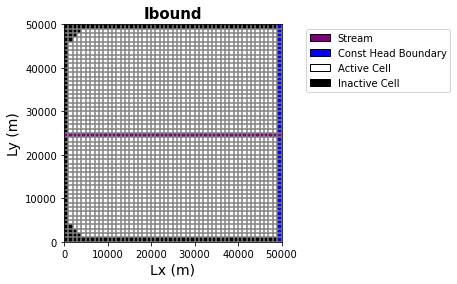

In [23]:
modelmap = flopy.plot.PlotMapView(model=m1, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
riv = modelmap.plot_bc("RIV", color='purple')
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

#### 3.5 Plot NTNA cross-section of subsurface layers

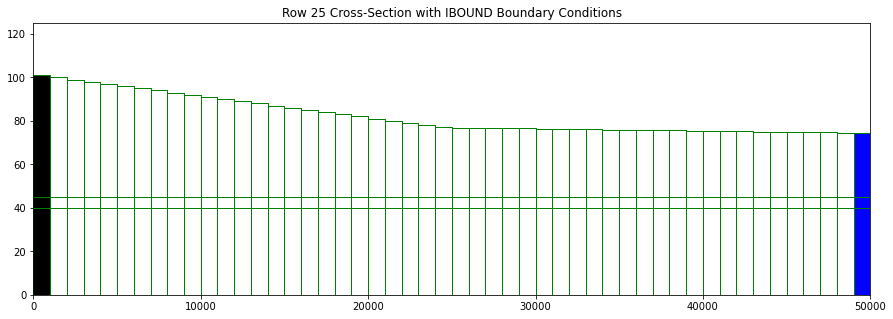

In [24]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='black', color_ch='blue')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

#### 3.6 Read in Outputs

In [25]:
# Head values
headobj1 = bf.HeadFile(modelname1+'.hds')    #reads the binary head file
times1 = headobj1.get_times()                 #returns a list of timesteps
head1 = headobj1.get_data(totim=times1[-1])   #returns a numpy array of heads for specified time (last timestep)

#Water balance
budgobj1 = bf.CellBudgetFile(modelname1+'.cbc')   #reads the cell budget file    
print(budgobj1.get_unique_record_names())
kstpkper_list = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf1 = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff1 = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 

#Get the ET from the cell budget files
et = budgobj1.get_data(text='et', totim=1.0)
et_vals = np.squeeze(et)[0,:,:] #This is a matrix of the ET fluxes [m3/day]
et_tot= np.sum(et_vals)
print("Total ET [m3/day]:", et_tot) #This is the total ET flux across the domain

#Get the recharge from the cell budget files
recharge1 = budgobj1.get_data(text='RECHARGE', totim=1.0) 
recharge_vals = np.squeeze(recharge1)[0,:,:] #This is a matrix of the recharge fluxes [m3/day]
rch_tot = np.sum(recharge_vals)
print("Total Recharge [m3/day]:", rch_tot)  # This is the total recharge flux across the domain


[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'   RIVER LEAKAGE', b'              ET', b'        RECHARGE']
Total ET [m3/day]: 3506.0
Total Recharge [m3/day]: 3506.0


#### 3.7 Plot ET, Recharge, and WTD
These plots clearly have issues as the recharge and ET values show the same behavior and have the same values as each other as seen by the water balance in the previous cell. The water table depth plot is also far too deep at one end and does not exhibit normal behavor.

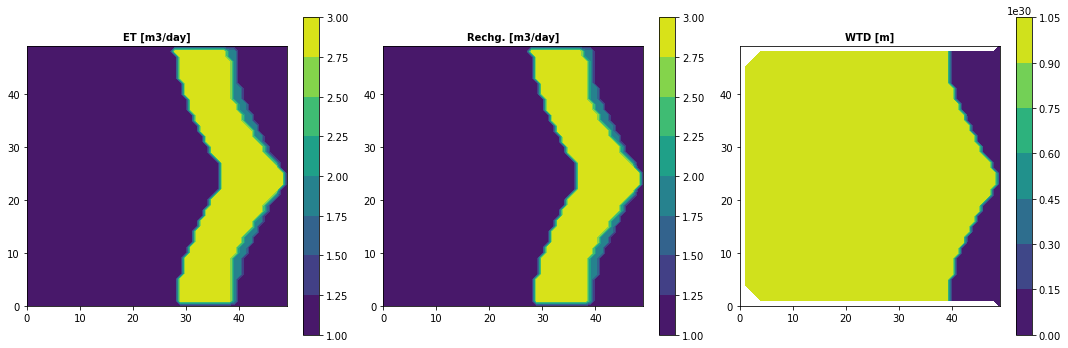

In [26]:
# Adjust head values
head_adj = head1.copy()
head_adj[head_adj == -999.99] = np.NAN

#Plot ET, Recharge and WTD
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
fig.tight_layout(pad=3.0)

#ET
#ax1.set_xlabel('Lx (m)', fontsize=10)
#ax1.set_ylabel('Ly (m)', fontsize=10)
ax1.set_title('ET [m3/day]', fontsize=10, fontweight='bold')
ax1.set_aspect('equal')
etplot = ax1.contourf(np.flipud(et_vals))
fig.colorbar(etplot, ax=ax1, shrink=0.3)

#Recharge
#ax2.set_xlabel('Lx (m)', fontsize=10)
#ax2.set_ylabel('Ly (m)', fontsize=10)
ax2.set_title('Rechg. [m3/day]', fontsize=10, fontweight='bold')
ax2.set_aspect('equal')
rchplot = ax2.contourf(np.flipud(recharge_vals))
fig.colorbar(rchplot, ax=ax2, shrink=0.3)

#WTD
#Calcualte WTD at the domain thickness (ztop) minus the head
WTD = ztop-head_adj
#ax3.set_xlabel('Lx (m)', fontsize=10)
#ax3.set_ylabel('Ly (m)', fontsize=10)
ax3.set_title('WTD [m]', fontsize=10, fontweight='bold')
ax3.set_aspect('equal')
wtdplot = ax3.contourf(np.flipud(WTD[0,:,:]))
fig.colorbar(wtdplot, ax=ax3, shrink=0.3)

fig.tight_layout()
plt.show()


### 3.8 Plot subsurface head cross section
These plots are intended to show the head distribution across the top layer of the subsurface cross-section (first plot) and the head distribution of the bottom layer of the subsurface. However, there are clearly issues with displaying these plots as the head values are not plotting properly. Ideally, there should be some sort of gradient from left to right.

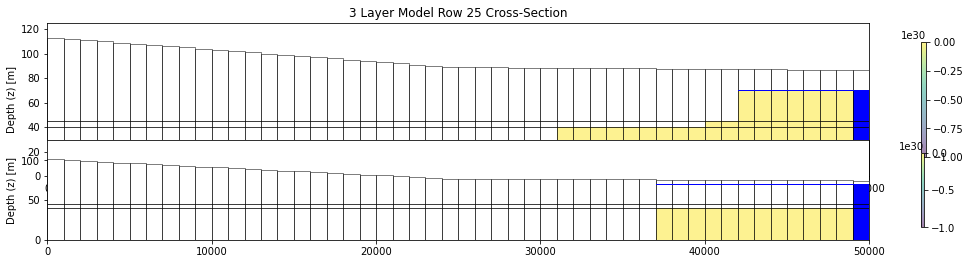

In [27]:

fig = plt.figure(figsize=(15, 5))
ax0 = fig.add_subplot(2, 1, 1)
fig.tight_layout()

# Top Layer Well - Ag Well
xsect0 = flopy.plot.PlotCrossSection(model=m1, line={'row': 12}) #note use the key 'column' if you want to plot a column instaed
pc = xsect0.plot_array(head1, masked_values=[-999.99], head=head1, alpha=0.5)
patches = xsect0.plot_ibound(head=head1)
# ax0.set_aspect('equal')
ax0.set_ylabel('Depth (z) [m]', fontsize=10)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect0.plot_grid(color='black', lw=0.5)
t = ax0.set_title('3 Layer Model Row 25 Cross-Section')
fig.colorbar(pc, ax=ax0, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect0.plot_surface(head1[0,:,:], masked_values=[-999.99], color='blue', lw=1)

ax1 = fig.add_subplot(3, 1, 2)
# 3 Layer Model Run 2
xsect1 = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc1 = xsect1.plot_array(head1, masked_values=[999.], head=head1, alpha=0.5)
patches = xsect1.plot_ibound(head=head1)
ax1.set_ylabel('Depth (z) [m]', fontsize=10)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect1.plot_grid(color='black', lw=0.5)
fig.colorbar(pc1, ax=ax1, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect1.plot_surface(head1[2,:,:], masked_values=[-999.99], color='blue', lw=1)


#### 3.9 Plot Drawdown in the top and bottom layers

C:\Users\conna\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\conna\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(
C:\Users\conna\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\conna\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be remo

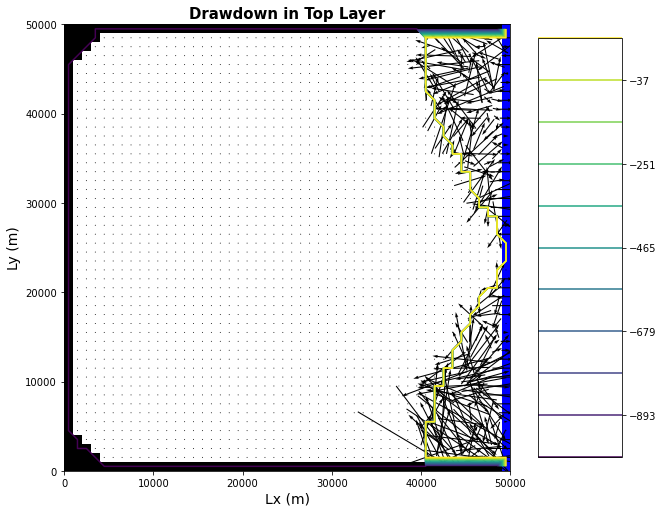

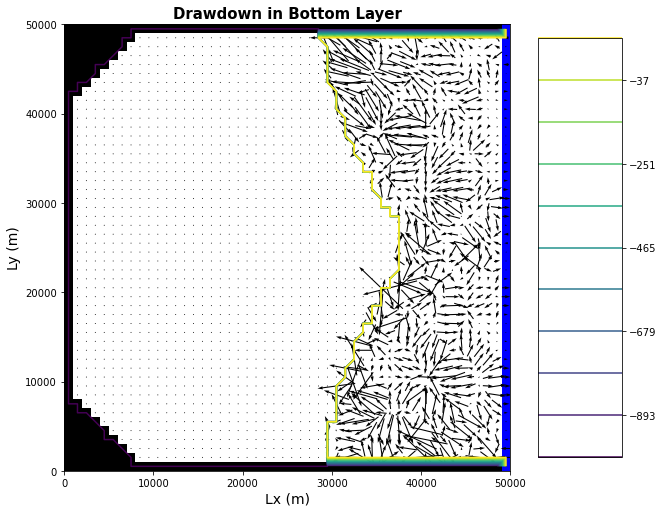

In [28]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig2=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m1, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head1[0][0].min(),head1[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head1, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf1[0], fff1[0], head=head1) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Drawdown in Top Layer', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')  


#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m1, layer=2) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head1[0][0].min(),head1[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head1, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf1[0], fff1[0], head=head1) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Drawdown in Bottom Layer', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   

## 4. Create Yes Town, No Ag Model (YTNA)

#### 4.1 Adjust the input variables to include Well

In [29]:
modelname2 = "YTNA_model"
m2 = flopy.modflow.Modflow(modelname2, exe_name = moddir)

# Well setup
pumping = -1500 #m3/day  #given
well_row = 21
well_col= 38
well_loc = (2,well_row,well_col) #Well loc should be layer, row, column
# print(well_loc)
well_1 = [i for i in well_loc] + [pumping]
wel_spd = {0: [well_1]} #putting the well in the bottom layer
#print(well_col)
print(well_1)

[2, 21, 38, -1500]


#### 4.2 Setup the stream package
Could not get the stream package to work properly, so it has been replaced throughout the code by the RIV package. The stream package code has been retained below for further debugging at a later date.

In [30]:
# Replace with RIV package

# # User inputs:
# nseg = 3
# ntrib = 2
# slope = 0.001                        #slope of streambed (m/m)
# rough = 0.04                         #roughness of streambed
# width = 1.                           #x-sectional width of channel (m)
# Flow_into_the_1st_reach = 0    # m^3/day
# Stage_above_datum = 0.5 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

# # str settings
# set_icalc = 1                   #1 if the stage is to be calculated based on flow, otherwise specify below
# const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
# istcb2 = 53                          #save outflows to cbb file

# # Calculate conductivity
# k_strbott = (1.36*K_horiz)                      #river bottom hydraulic conductivity in f/d
# sed_thick = 1                      #thickness of riverbed sediment in f

# str_cond = (k_strbott*(dy)*(width))/(sed_thick) #river bed conductance in f^2/d

# # Setup reach locations
# nreach = 50
# str_rows = 24*np.ones((nreach),dtype=np.int32)
# str_cols = np.arange(0,nreach)

# # Setup reach inflows
# Qreturn = 0        # Return flow from town (Set to zero when town not present in model)
# return_loc = 24     # Cell location of return flow from town to stream
# reach_flow = np.zeros((nreach),dtype=np.int32)      # initially sets all inflows to zero for all reaches
# reach_flow[return_loc] = Qreturn      # inflow to segment 2 --> return from town
# reach_flow[return_loc+1] = -1         # inflow to segment 3 --> sum of all previous segments

# # Setup segment numbers
# segments = np.ones((nreach),dtype=np.int32)
# segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
# segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

# # Setup reach numbers (Numbers reaches within each segment) 
# reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50 (numbering moves downstream)
# reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
# reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

# # Setup the elevation of the stream segments
# ztop = np.genfromtxt('base_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
# surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream
# # loop over the stream reaches and pull the land surface elevation for the location of each stream cell
# for i in np.arange(nreach): 
#       surf_elev[i] = ztop[str_rows[i],str_cols[i]]
# str_top = surf_elev -  1.    # elevation of the top of the streambed (1 m below land surface) (m)
# str_bot = str_top - sed_thick      # elevation of the bottom of the streambed (m)
# stage_elev = str_top + Stage_above_datum      # elevation of the water surface in the stream (m)

# # Setup the stress period dictionary
# str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values
# # Loop over the reaches and setup the data
# for r in np.arange(nreach): 
#      str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], 
#                       str_cond, str_bot[r], str_top[r], width, slope, rough]
# str_spd = {0: str_info} # save the stream info in a stress period dictionary

# # Setup the segments dictionary
# #for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
# seg_info = np.zeros((10,nseg))
# seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
# str_segd = {0: seg_info}  #save the stream info in a segment dictionary

# strm = flopy.modflow.mfstr.ModflowStr(m2, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')


#### 4.3 Set up RIV package

In [31]:
#assign heads at start and end of stress period
strt_head=70
end_head=70
#create list to hold stress period constant head boundary condition cells
bound_sp1 = []

#assign constant head boundary cells on the left and right boundaries
for lay in range(nlay_sub):
    for row in range(nrow):
        bound_sp1.append([lay,row,ncol-1,strt_head,end_head])

#create dictionary with stress period data
chd_spd={0: bound_sp1}

#create flopy CHD object, and attach to model
chd = flopy.modflow.ModflowChd(model=m1, stress_period_data=chd_spd)


# Set River package variables
riv_sp = []    # create list to store all river cells for stress period 1
k_rivbott = (1.36*K_horiz)     # river bottom hydraulic conductivity in m/d
sed_thick = 1 # thickness of riverbed sediment
width = 1.                           # width of channel 
cond = k_rivbott*(dy)*(width)/(sed_thick) #river bed conductance in m^2/d
r_stage = 0.5 # stage in river

r_bot = -0.5    # river bottom elevation is set to -0.5 m because it is assumed that the river stage is 1 m above this value

# assign river data to cells in central column
for i in range(nrow):
    riv_sp.append([0, nrow/2, i, r_stage, cond, r_bot])

# create dictionary of stress period data
riv_spd = {0: riv_sp}

# Run river package
riv = flopy.modflow.ModflowRiv(model=m1, stress_period_data=riv_spd, ipakcb=53)

#### 4.4 Setup basic MODFLOW packages and run YTNA model

In [32]:
# Put all of the basic packages in here

# Discretization - dis
dis = flopy.modflow.ModflowDis(model=m2, nlay=nlay_sub, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# bas package
bas = flopy.modflow.ModflowBas(m2, ibound=ibound, strt=H_init)

# Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m2, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)

# Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m2, rech=rech_zone, ipakcb=53)

# ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(model=m2, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53)

# Well - wel
wel = flopy.modflow.ModflowWel(model=m2, stress_period_data=wel_spd)

# Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m2, stress_period_data=spd, compact=True)

# Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m2)

# write the inputs
m2.write_input()

# Run the model 
success, mfoutput = m2.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


FloPy is using the following executable to run the model: ../../../GW_Homework/Submissions/HW12/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: YTNA_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/22  1:34:10

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/22  1:34:10
 Elapsed run time:  0.076 Seconds

  Normal termination of simulation


### 4.5 Plot YTNA model grid and boundary conditions
Received an error message when trying to plot the stream on this domain view. The stream is still included in the model, however.

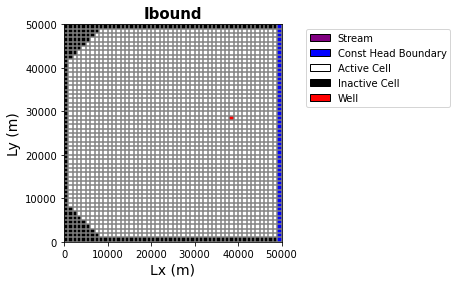

In [33]:
modelmap = flopy.plot.PlotMapView(model=m2, layer=2)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
wel_m = modelmap.plot_bc("WEL")
# riv = modelmap.plot_bc("RIV", color='purple')
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   mp.patches.Patch(color='red', label='Well',ec='black')],
                                      bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

### 4.6 Plot YTNA cross section of subsurface layers

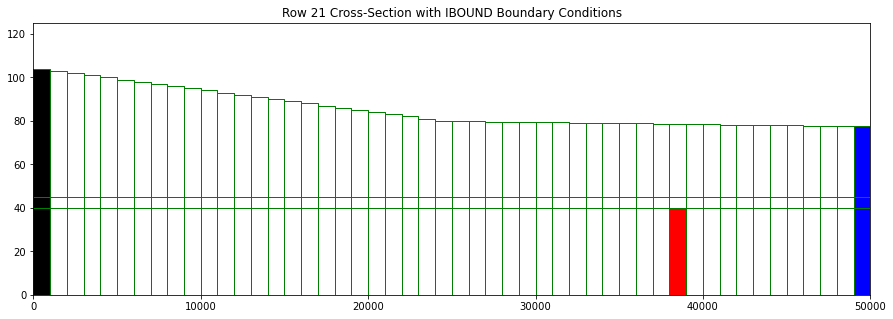

In [34]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m2, line={'row': 21}) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='black', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 21 Cross-Section with IBOUND Boundary Conditions')

#### 4.7 Read in Outputs

In [35]:
# Head values
headobj2 = bf.HeadFile(modelname2+'.hds')    #reads the binary head file
times2 = headobj2.get_times()                 #returns a list of timesteps
head2 = headobj2.get_data(totim=times2[-1])   #returns a numpy array of heads for specified time (last timestep)

#Water balance
budgobj2 = bf.CellBudgetFile(modelname2+'.cbc')   #reads the cell budget file    
print(budgobj2.get_unique_record_names())
kstpkper_list = budgobj2.get_kstpkper()          #returns a list of stress periods & timesteps
frf2 = budgobj2.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff2 = budgobj2.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 

#Get the ET from the cell budget files
et = budgobj2.get_data(text='et', totim=1.0)
et_vals = np.squeeze(et)[0,:,:] #This is a matrix of the ET fluxes [m3/day]
et_tot= np.sum(et_vals)
print("Total ET [m3/day]:", et_tot) #This is the total ET flux across the domain

#Get the recharge from the cell budget files
recharge3 = budgobj2.get_data(text='RECHARGE', totim=1.0) 
recharge_vals = np.squeeze(recharge3)[0,:,:] #This is a matrix of the recharge fluxes [m3/day]
rch_tot = np.sum(recharge_vals)
print("Total Recharge [m3/day]:", rch_tot)  # This is the total recharge flux across the domain


[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'        RECHARGE']
Total ET [m3/day]: 3644.0
Total Recharge [m3/day]: 3644.0


#### 4.8 Plot ET, Recharge, and WTD
These plots clearly have issues as the recharge and ET values show the same behavior and have the same values as each other as seen by the water balance in the previous cell. The water table depth plot is also far too deep at one end and does not exhibit normal behavor.

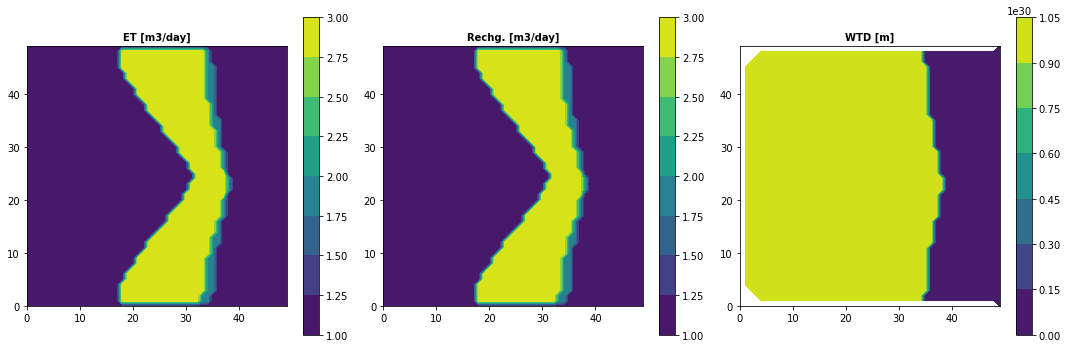

In [36]:
# Adjust head values
head_adj = head2.copy()
head_adj[head_adj == -999.99] = np.NAN

#Plot ET, Recharge and WTD
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
fig.tight_layout(pad=3.0)

#ET
#ax1.set_xlabel('Lx (m)', fontsize=10)
#ax1.set_ylabel('Ly (m)', fontsize=10)
ax1.set_title('ET [m3/day]', fontsize=10, fontweight='bold')
ax1.set_aspect('equal')
etplot = ax1.contourf(np.flipud(et_vals))
fig.colorbar(etplot, ax=ax1, shrink=0.3)

#Recharge
#ax2.set_xlabel('Lx (m)', fontsize=10)
#ax2.set_ylabel('Ly (m)', fontsize=10)
ax2.set_title('Rechg. [m3/day]', fontsize=10, fontweight='bold')
ax2.set_aspect('equal')
rchplot = ax2.contourf(np.flipud(recharge_vals))
fig.colorbar(rchplot, ax=ax2, shrink=0.3)

#WTD
#Calcualte WTD at the domain thickness (ztop) minus the head
WTD = ztop-head_adj
#ax3.set_xlabel('Lx (m)', fontsize=10)
#ax3.set_ylabel('Ly (m)', fontsize=10)
ax3.set_title('WTD [m]', fontsize=10, fontweight='bold')
ax3.set_aspect('equal')
wtdplot = ax3.contourf(np.flipud(WTD[0,:,:]))
fig.colorbar(wtdplot, ax=ax3, shrink=0.3)

fig.tight_layout()
plt.show()


#### 4.9 Plot subsurface head cross section

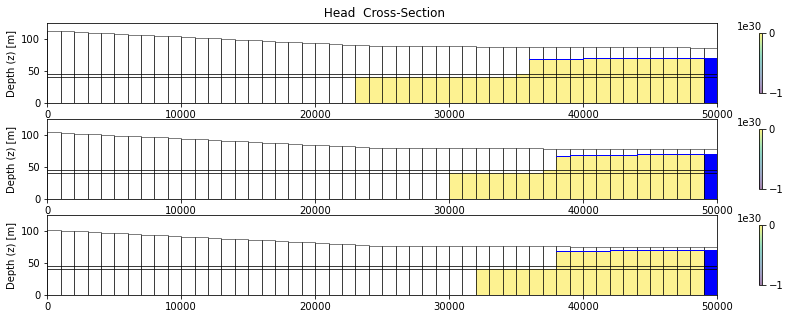

In [37]:

fig = plt.figure(figsize=(15, 5))
ax0 = fig.add_subplot(3, 1, 1)

# Top Layer Well - Ag Well
xsect0 = flopy.plot.PlotCrossSection(model=m2, line={'row': 12}) #note use the key 'column' if you want to plot a column instaed
pc = xsect0.plot_array(head2, masked_values=[-999.99], head=head2, alpha=0.5)
patches = xsect0.plot_ibound(head=head2)
# ax0.set_aspect('equal')
ax0.set_ylabel('Depth (z) [m]', fontsize=10)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect0.plot_grid(color='black', lw=0.5)
t = ax0.set_title(' Head  Cross-Section')
fig.colorbar(pc, ax=ax0, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect0.plot_surface(head2[0,:,:], masked_values=[-999.99], color='blue', lw=1)


# Along stream
ax1 = fig.add_subplot(3, 1, 2)

xsect1 = flopy.plot.PlotCrossSection(model=m2, line={'row': 21}) #note use the key 'column' if you want to plot a column instaed
pc1 = xsect1.plot_array(head2, masked_values=[-999.99], head=head2, alpha=0.5)
patches = xsect1.plot_ibound(head=head2)
ax1.set_ylabel('Depth (z) [m]', fontsize=10)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect1.plot_grid(color='black', lw=0.5)
fig.colorbar(pc1, ax=ax1, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect1.plot_surface(head2[0,:,:], masked_values=[-999.99], color='blue', lw=1)


# Bottom layer Well - Town Well
ax2 = fig.add_subplot(3, 1, 3)
# 3 Layer Model Run 2
xsect2 = flopy.plot.PlotCrossSection(model=m2, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc2 = xsect2.plot_array(head2, masked_values=[-999.99], head=head2, alpha=0.5)
patches = xsect2.plot_ibound(head=head2)
ax2.set_ylabel('Depth (z) [m]', fontsize=10)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect2.plot_grid(color='black', lw=0.5)
fig.colorbar(pc2, ax=ax2, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect2.plot_surface(head2[0,:,:], masked_values=[-999.99], color='blue', lw=1)

#### 4.10 Plot Drawdown in the top and bottom layers
Water is being pumped out of the well located in the town at a high rate and the left half of the flow domain seems to dry out and reduce the chance for flow to either of the two wells from the left side. Flow from the right side of the domain is very high, and there seems to be higher drawdown in the top layer for the Town Well than in the lowest layer.

C:\Users\conna\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\conna\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(
C:\Users\conna\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\conna\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be remo

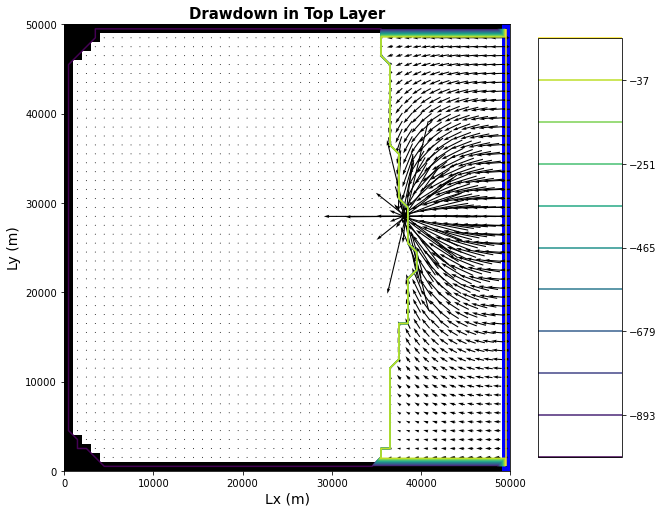

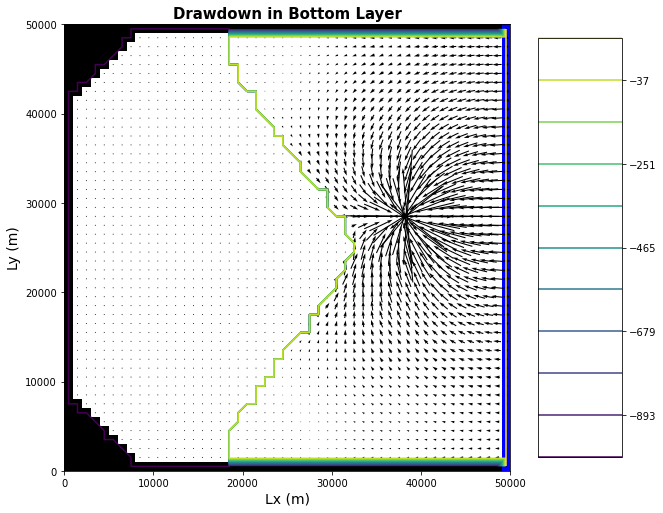

In [38]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig2=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m2, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head2[0][0].min(),head2[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head2, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf2[0], fff2[0], head=head2) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Drawdown in Top Layer', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')  


#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m2, layer=2) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head2[0][0].min(),head2[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head2, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf2[0], fff2[0], head=head2) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Drawdown in Bottom Layer', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   

## 5. Create Yes Town, Yes Ag Model (YTYA)

#### 5.1 Adjust the input variables to include Well and Ag

In [39]:
modelname3 = "YTYA_model"
m3 = flopy.modflow.Modflow(modelname3, exe_name = moddir)

# Well setup
pumping = -1500 #m3/day  #given
well_row = 21
well_col= 38
well_loc = (2,well_row,well_col) #Well loc should be layer, row, column
# print(well_loc)
well_1 = [i for i in well_loc] + [pumping]
#print(well_col)
print(well_1)

# AG FIELD
# Recharge
crop_dem = 0.006
field_rech = (crop_dem*0.2*0.125)        # Assuming field growing pistachios, crop demand of 0.006 m/day --> 0.006*0.125*0.2
rech_zone[21:23,19:21] = field_rech

# Well
pumping = -4500 #m3/day  #given
well_row = 12
well_col= 14
well_loc = (0,well_row,well_col) #Well loc should be layer, row, column
well_2 = [i for i in well_loc] + [pumping]
wel_spd = {0: [well_1, well_2]} #putting the well in the bottom layer
# print(well_loc)
print(well_2)

[2, 21, 38, -1500]
[0, 12, 14, -4500]


#### 5.2 Setup the stream package
Could not get the stream package to work properly, so it has been replaced throughout the code by the RIV package. The stream package code has been retained below for further debugging at a later date.

In [40]:
# Replace with RIV package

# # Which layer is the strea plotting in?

# # User inputs:
# nseg = 3
# ntrib = 2
# slope = 0.001                        #slope of streambed (m/m)
# rough = 0.04                         #roughness of streambed
# width = 1.                           #x-sectional width of channel (m)
# Flow_into_the_1st_reach = 0    # m^3/day
# Stage_above_datum = 0.5 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

# # str settings
# set_icalc = 1                   #1 if the stage is to be calculated based on flow, otherwise specify below
# const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
# istcb2 = 53                          #save outflows to cbb file

# # Calculate conductivity
# k_strbott = (1.36*K_horiz)                      #river bottom hydraulic conductivity in f/d
# sed_thick = 1                      #thickness of riverbed sediment in f

# str_cond = (k_strbott*(dy)*(width))/(sed_thick) #river bed conductance in f^2/d

# # Setup reach locations
# nreach = 50
# str_rows = 24*np.ones((nreach),dtype=np.int32)
# str_cols = np.arange(0,nreach)

# # Setup reach inflows
# Qreturn = 0        # Return flow from town (Set to zero when town not present in model)
# return_loc = 24     # Cell location of return flow from town to stream
# reach_flow = np.zeros((nreach),dtype=np.int32)      # initially sets all inflows to zero for all reaches
# reach_flow[return_loc] = Qreturn      # inflow to segment 2 --> return from town
# reach_flow[return_loc+1] = -1         # inflow to segment 3 --> sum of all previous segments

# # Setup segment numbers
# segments = np.ones((nreach),dtype=np.int32)
# segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
# segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

# # Setup reach numbers (Numbers reaches within each segment) 
# reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50 (numbering moves downstream)
# reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
# reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

# # Setup the elevation of the stream segments
# ztop = np.genfromtxt('base_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
# surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream
# # loop over the stream reaches and pull the land surface elevation for the location of each stream cell
# for i in np.arange(nreach): 
#       surf_elev[i] = ztop[str_rows[i],str_cols[i]]
# str_top = surf_elev -  1.    # elevation of the top of the streambed (1 m below land surface) (m)
# str_bot = str_top - sed_thick      # elevation of the bottom of the streambed (m)
# stage_elev = str_top + Stage_above_datum      # elevation of the water surface in the stream (m)

# # Setup the stress period dictionary
# str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values
# # Loop over the reaches and setup the data
# for r in np.arange(nreach): 
#      str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], 
#                       str_cond, str_bot[r], str_top[r], width, slope, rough]
# str_spd = {0: str_info} # save the stream info in a stress period dictionary

# # Setup the segments dictionary
# #for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
# seg_info = np.zeros((10,nseg))
# seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
# str_segd = {0: seg_info}  #save the stream info in a segment dictionary

# strm = flopy.modflow.mfstr.ModflowStr(m3, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')


#### 5.3 Set up RIV package

In [41]:
#assign heads at start and end of stress period
strt_head=70
end_head=70
#create list to hold stress period constant head boundary condition cells
bound_sp1 = []

#assign constant head boundary cells on the left and right boundaries
for lay in range(nlay_sub):
    for row in range(nrow):
        bound_sp1.append([lay,row,ncol-1,strt_head,end_head])

#create dictionary with stress period data
chd_spd={0: bound_sp1}

#create flopy CHD object, and attach to model
chd = flopy.modflow.ModflowChd(model=m1, stress_period_data=chd_spd)


# Set River package variables
riv_sp = []    # create list to store all river cells for stress period 1
k_rivbott = (1.36*K_horiz)     # river bottom hydraulic conductivity in m/d
sed_thick = 1 # thickness of riverbed sediment
width = 1.                           # width of channel 
cond = k_rivbott*(dy)*(width)/(sed_thick) #river bed conductance in m^2/d
r_stage = 0.5 # stage in river

r_bot = -0.5    # river bottom elevation is set to -0.5 m because it is assumed that the river stage is 1 m above this value

# assign river data to cells in central column
for i in range(nrow):
    riv_sp.append([0, nrow/2, i, r_stage, cond, r_bot])

# create dictionary of stress period data
riv_spd = {0: riv_sp}

# Run river package
riv = flopy.modflow.ModflowRiv(model=m1, stress_period_data=riv_spd, ipakcb=53)

#### 5.4 Setup basic MODFLOW packages and run YTYA model

In [42]:
# Put all of the basic packages in here

# Discretization - dis
dis = flopy.modflow.ModflowDis(model=m3, nlay=nlay_sub, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# bas package
bas = flopy.modflow.ModflowBas(m3, ibound=ibound, strt=H_init)

# Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)

# Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m3, rech=rech_zone, ipakcb=53)

# ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(model=m3, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53)

# Well - wel
wel = flopy.modflow.ModflowWel(model=m3, stress_period_data=wel_spd)

# Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3, stress_period_data=spd, compact=True)

# Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3)

# write the inputs
m3.write_input()

# Run the model 
success, mfoutput = m3.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


FloPy is using the following executable to run the model: ../../../GW_Homework/Submissions/HW12/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: YTYA_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/22  1:34:13

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/22  1:34:13
 Elapsed run time:  0.077 Seconds

  Normal termination of simulation


#### 5.5 Plot YTYA model grid and boundary conditions
The same issue seen with the RIV plotting for model 2 is seen here. It seems to be an issue with the RIV package plotting, but I was unsure how to fix this issue.

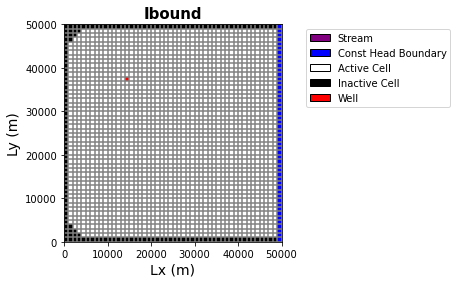

In [43]:
modelmap = flopy.plot.PlotMapView(model=m3, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
wel_m = modelmap.plot_bc("WEL")
# riv = modelmap.plot_bc("RIV", color='purple')
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   mp.patches.Patch(color='red', label='Well',ec='black')],
                                      bbox_to_anchor=(1.8,1.0))
# plt.show(modelmap)

#### 5.6 Plot YTYA cross section of subsurface layers
This plot shows the location of the two groundwater well screening areas within the subsurface of the flow domain.

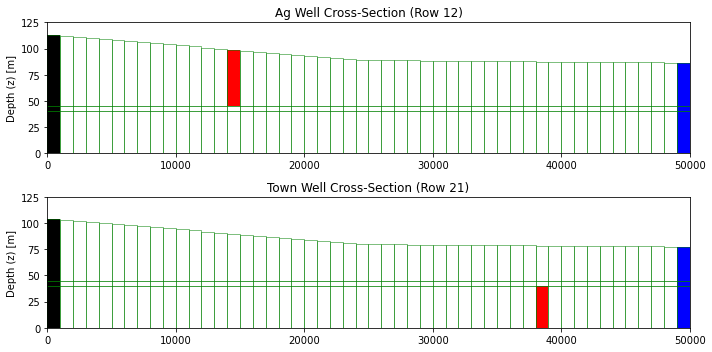

In [44]:
fig = plt.figure(figsize=(10, 5))
ax0 = fig.add_subplot(2, 1, 1)

# Top Layer Well - Ag Well
xsect0 = flopy.plot.PlotCrossSection(model=m3, line={'row': 12}) #note use the key 'column' if you want to plot a column instaed
patches = xsect0.plot_ibound(color_noflow='black', color_ch='blue')
patches = xsect0.plot_bc('WEL', color='red', label='Ag Well')
linecollection = xsect0.plot_grid(color='green', lw=0.5)
# ax0.set_aspect('equal')
ax0.set_ylabel('Depth (z) [m]', fontsize=10)
t = ax0.set_title('Ag Well Cross-Section (Row 12)')
# plt.legend()

# Bottom Layer Well - Town Well
ax1 = fig.add_subplot(2, 1, 2)
xsect1 = flopy.plot.PlotCrossSection(model=m3, line={'row': 21}) #note use the key 'column' if you want to plot a column instaed
patches1 = xsect1.plot_ibound(color_noflow='Black', color_ch='blue')
patches1 = xsect1.plot_bc('WEL', color='red', label= 'Town Well')
linecollection = xsect1.plot_grid(color='green', lw=0.5)
ax1.set_ylabel('Depth (z) [m]', fontsize=10)
t1 = ax1.set_title('Town Well Cross-Section (Row 21)')
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# plt.legend()
fig.tight_layout()

#### 5.7 Read in outputs

In [45]:
# Head values
headobj3 = bf.HeadFile(modelname3+'.hds')    #reads the binary head file
times3 = headobj3.get_times()                 #returns a list of timesteps
head3 = headobj3.get_data(totim=times3[-1])   #returns a numpy array of heads for specified time (last timestep)

#Water balance
budgobj3 = bf.CellBudgetFile(modelname3+'.cbc')   #reads the cell budget file    
print(budgobj3.get_unique_record_names())
kstpkper_list = budgobj3.get_kstpkper()          #returns a list of stress periods & timesteps
frf3 = budgobj3.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3 = budgobj3.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 

#Get the ET from the cell budget files
et = budgobj3.get_data(text='et', totim=1.0)
et_vals = np.squeeze(et)[0,:,:] #This is a matrix of the ET fluxes [m3/day]
et_tot= np.sum(et_vals)
print("Total ET [m3/day]:", et_tot) #This is the total ET flux across the domain

#Get the recharge from the cell budget files
recharge3 = budgobj3.get_data(text='RECHARGE', totim=1.0) 
recharge_vals = np.squeeze(recharge3)[0,:,:] #This is a matrix of the recharge fluxes [m3/day]
rch_tot = np.sum(recharge_vals)
print("Total Recharge [m3/day]:", rch_tot)  # This is the total recharge flux across the domain


[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'        RECHARGE']
Total ET [m3/day]: 3706.0
Total Recharge [m3/day]: 3706.0


#### 5.8 Plot ET, Recharge, and WTD
These plots clearly have issues as the recharge and ET values show the same behavior and have the same values as each other as seen by the water balance in the previous cell. The water table depth plot is also far too deep at one end and does not exhibit normal behavor.

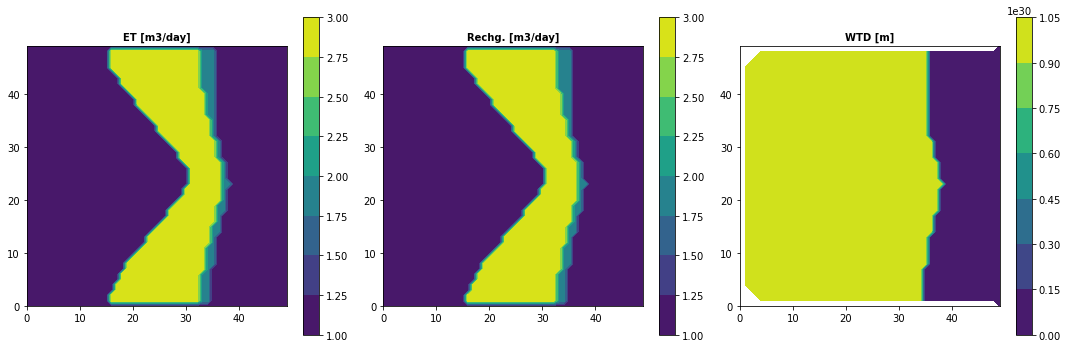

In [46]:
# Adjust head values
head_adj = head3.copy()
head_adj[head_adj == -999.99] = np.NAN

#Plot ET, Recharge and WTD
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
fig.tight_layout(pad=3.0)

#ET
#ax1.set_xlabel('Lx (m)', fontsize=10)
#ax1.set_ylabel('Ly (m)', fontsize=10)
ax1.set_title('ET [m3/day]', fontsize=10, fontweight='bold')
ax1.set_aspect('equal')
etplot = ax1.contourf(np.flipud(et_vals))
fig.colorbar(etplot, ax=ax1, shrink=0.3)

#Recharge
#ax2.set_xlabel('Lx (m)', fontsize=10)
#ax2.set_ylabel('Ly (m)', fontsize=10)
ax2.set_title('Rechg. [m3/day]', fontsize=10, fontweight='bold')
ax2.set_aspect('equal')
rchplot = ax2.contourf(np.flipud(recharge_vals))
fig.colorbar(rchplot, ax=ax2, shrink=0.3)

#WTD
#Calcualte WTD at the domain thickness (ztop) minus the head
WTD = ztop-head_adj
#ax3.set_xlabel('Lx (m)', fontsize=10)
#ax3.set_ylabel('Ly (m)', fontsize=10)
ax3.set_title('WTD [m]', fontsize=10, fontweight='bold')
ax3.set_aspect('equal')
wtdplot = ax3.contourf(np.flipud(WTD[0,:,:]))
fig.colorbar(wtdplot, ax=ax3, shrink=0.3)

fig.tight_layout()
plt.show()


#### 5.9 Plot subsurface head cross section
This code is flawed, like the ones before, and I could not figure out how to fix it.

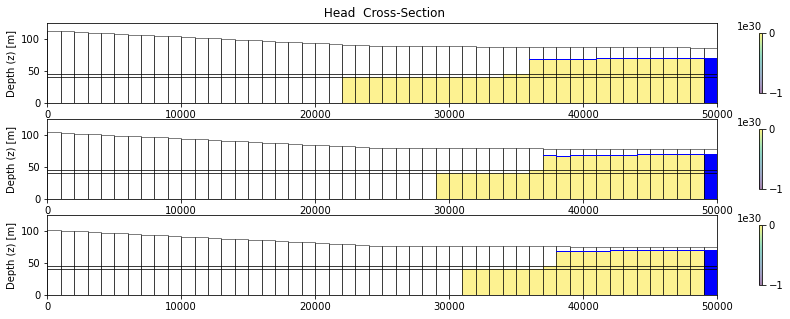

In [47]:

fig = plt.figure(figsize=(15, 5))
ax0 = fig.add_subplot(3, 1, 1)

# Top Layer Well - Ag Well
xsect0 = flopy.plot.PlotCrossSection(model=m3, line={'row': 12}) #note use the key 'column' if you want to plot a column instaed
pc = xsect0.plot_array(head3, masked_values=[-999.99], head=head3, alpha=0.5)
patches = xsect0.plot_ibound(head=head3)
# ax0.set_aspect('equal')
ax0.set_ylabel('Depth (z) [m]', fontsize=10)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect0.plot_grid(color='black', lw=0.5)
t = ax0.set_title(' Head  Cross-Section')
fig.colorbar(pc, ax=ax0, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect0.plot_surface(head3[0,:,:], masked_values=[-999.99], color='blue', lw=1)


# Along stream
ax1 = fig.add_subplot(3, 1, 2)

xsect1 = flopy.plot.PlotCrossSection(model=m3, line={'row': 21}) #note use the key 'column' if you want to plot a column instaed
pc1 = xsect1.plot_array(head3, masked_values=[-999.99], head=head3, alpha=0.5)
patches = xsect1.plot_ibound(head=head3)
ax1.set_ylabel('Depth (z) [m]', fontsize=10)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect1.plot_grid(color='black', lw=0.5)
fig.colorbar(pc1, ax=ax1, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect1.plot_surface(head3[0,:,:], masked_values=[-999.99], color='blue', lw=1)


# Bottom layer Well - Town Well
ax2 = fig.add_subplot(3, 1, 3)
# 3 Layer Model Run 2
xsect2 = flopy.plot.PlotCrossSection(model=m3, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc2 = xsect2.plot_array(head3, masked_values=[-999.99], head=head3, alpha=0.5)
patches = xsect2.plot_ibound(head=head3)
ax2.set_ylabel('Depth (z) [m]', fontsize=10)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect2.plot_grid(color='black', lw=0.5)
fig.colorbar(pc2, ax=ax2, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect2.plot_surface(head3[0,:,:], masked_values=[-999.99], color='blue', lw=1)

#### 5.10 Plot Drawdown in the top and bottom layers
This plot has issues as well. The left half of the domain is not plotting correctly and is drying out the system, whereas the right side of the each plot shows significant water being pumped out of the well located in the town

C:\Users\conna\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\conna\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(
C:\Users\conna\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\conna\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be remo

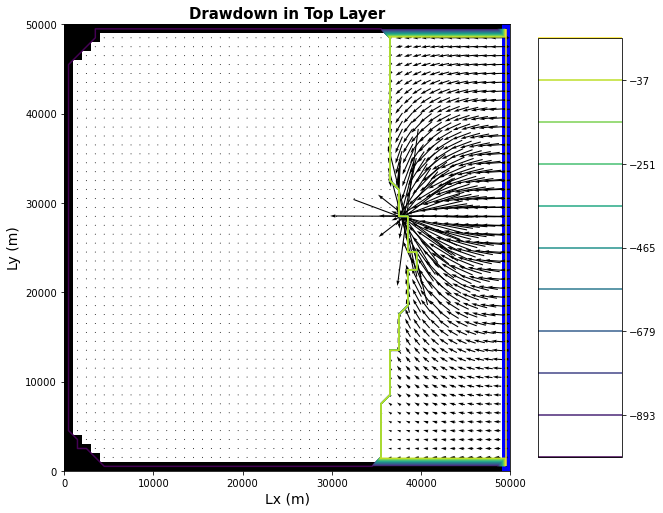

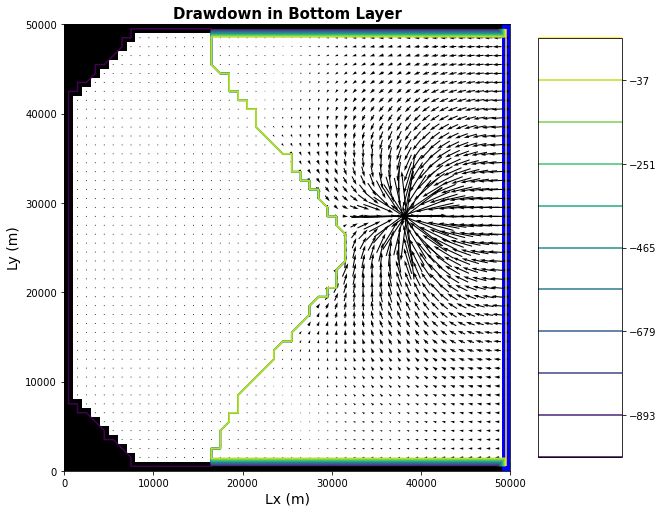

In [48]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig2=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m3, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head3[0][0].min(),head3[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head3, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf3[0], fff3[0], head=head3) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Drawdown in Top Layer', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')  


#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m3, layer=2) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head3[0][0].min(),head3[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head3, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf3[0], fff3[0], head=head3) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Drawdown in Bottom Layer', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   